https://machine-learning.club

In [277]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


In [96]:
def create_dummies(data, column_name: str, prefix_name: str):
    dummie = pd.get_dummies(data[column_name], prefix=prefix_name) # Create columsn for all the possibilities in column
    dummie = dummie.astype(int) # Convert boolean values to integers
    data.drop(column_name, axis=1, inplace=True) # Drop the attribute
    return dummie

In [220]:
def get_importances(clf):
	# Dictionary: Feature → Importance in %
    importances = {
        feature: round(importance * 100, 2)
        for feature, importance in zip(clf.feature_names_in_, clf.feature_importances_)
    }
    
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    formatted = [f"'{feature}' impact: {importance:.2f}%" for feature, importance in sorted_importances]
    return formatted

In [263]:
def get_grid(model_regressor, x_train, y_train) -> GridSearchCV:
    # to get the max depth we search for the perfect grid
	param_grid = {
    'max_depth': list(range(2, 21)),
    'criterion': ['gini', 'entropy']
	}	
	find_grid = GridSearchCV(
		estimator=model_regressor,
  		scoring='f1',
		param_grid=param_grid,
		cv=5, # cross-validation with 5 folds
	)
	find_grid.fit(x_train, y_train)
	return find_grid

In [98]:
data = pd.read_csv("data/training_data.csv")

# Get all dummies
gender_dummie = create_dummies(data, "gender", "gender")
work_dummie = create_dummies(data, "work_type", "work")
smoking_dummie = create_dummies(data, "smoking_status", "smoking_status")
residence_dummie = create_dummies(data, "Residence_type", "Residence_type")
married_dummie = create_dummies(data, "ever_married", "married")

# Add all dummies to one data frame & add it to the main data frame
data_dummies = pd.concat([gender_dummie, work_dummie, smoking_dummie, residence_dummie, married_dummie], axis=1)
data = pd.concat([data, data_dummies], axis=1)

# Drop the following columns
data = data.drop(["id"], axis=1)

### Later for the solution

In [ ]:
x_train = data.drop("stroke", axis=1)
y_train = data["stroke"]

# TODO: change class_weight
clf = DecisionTreeClassifier(criterion='entropy', random_state=42, class_weight={0: 1, 1: 90})
clf = clf.fit(x_train,y_train)


find_grid = get_grid(clf, x_train, y_train)
max_depth = find_grid.best_params_['max_depth']

print("Best max_depth:", max_depth)

Best max_depth: 14


### To fine tune the Classifier

In [ ]:
from sklearn.model_selection import train_test_split

x = data.drop("stroke", axis=1)
y = data["stroke"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.4)

# entropy == information gain
# max_depth from the markdown above
# TODO: change class_weight
clf = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth, class_weight={0: 1, 1: 90})
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acc = f1_score(y_test,y_pred,average='binary')
print(f"F1 Score: {round(acc * 100, 2)}% \n")

for value in get_importances(clf):
	print(value)
 


F1 Score: 13.95% 

'age' impact: 45.15%
'bmi' impact: 21.97%
'avg_glucose_level' impact: 20.34%
'smoking_status_Unknown' impact: 2.00%
'work_Private' impact: 1.92%
'married_Yes' impact: 1.63%
'gender_Female' impact: 1.15%
'work_Self-employed' impact: 1.02%
'smoking_status_formerly smoked' impact: 0.98%
'smoking_status_never smoked' impact: 0.93%
'Residence_type_Rural' impact: 0.89%
'smoking_status_smokes' impact: 0.85%
'heart_disease' impact: 0.46%
'hypertension' impact: 0.44%
'Residence_type_Urban' impact: 0.17%
'gender_Male' impact: 0.10%
'work_Govt_job' impact: 0.02%
'gender_Other' impact: 0.00%
'work_Never_worked' impact: 0.00%
'work_children' impact: 0.00%
'married_No' impact: 0.00%


In [ ]:
# Shows us how imbalanced the stroke is -> reason for the bad results
print(pd.Series(y_train).value_counts(normalize=True))


stroke
0    0.944943
1    0.055057
Name: proportion, dtype: float64


The reason why the most of our true labeled are 0-0, but we want more of 1-1

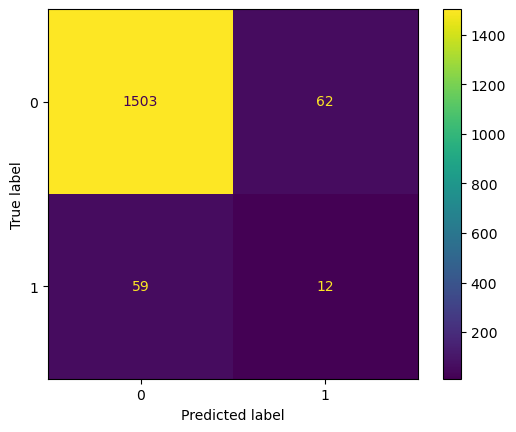

In [274]:
# plot confusions matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# plot decussion tree
#tree.plot_tree(clf)